In [1]:
import pandas as pd
import os
import numpy as np
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.layers import Dense, Flatten, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

class TQDMNotebookCallback(tf.keras.callbacks.Callback):
    def __init__(self, epochs):
        self.epochs = epochs
        self.pbar = tqdm(total=epochs, desc="Training Progress", unit="epoch")

    def on_epoch_end(self, epoch, logs=None):
        self.pbar.update(1)
        self.pbar.set_postfix(loss=logs.get('loss'), accuracy=logs.get('accuracy'),
                              val_loss=logs.get('val_loss'), val_accuracy=logs.get('val_accuracy'))


# Load classification labels
labels_df = pd.read_csv('Data/Input/classification_labels.csv')
labels_df['basename'] = labels_df['basename'].apply(lambda x: f"{x}.jpg")  # Ensure filenames have .jpg extension
labels_df = labels_df.rename(columns={"basename": "filename", "deepest_name": "label"})

# Load family tree data
family_tree_df = pd.read_excel('Data/Input/name_to_ancestors.xlsx')

# Display the first few rows of the labels and family tree data
labels_df.head(), family_tree_df.head()


(                        filename         label  \
 0  213_20210905050256_2415_t.jpg    Limoniidae   
 1   192_20200724194326_17604.jpg      Caenidae   
 2   294_20210814023615_30831.jpg  Cicadellidae   
 3   146_20200616021921_26547.jpg     Crambidae   
 4   118_20200827021322_36091.jpg    Collembola   
 
                                                names  
 0   ['Insecta', 'Animalia', 'Diptera', 'Limoniidae']  
 1  ['Caenidae', 'Ephemeroptera', 'Insecta', 'Anim...  
 2  ['Insecta', 'Cicadellidae', 'Animalia', 'Hemip...  
 3  ['Insecta', 'Animalia', 'Crambidae', 'Lepidopt...  
 4           ['Animalia', 'Collembola', 'Entognatha']  ,
           name                               ancestors
 0     Animalia                            ['Animalia']
 1      Insecta                 ['Insecta', 'Animalia']
 2  Hymenoptera  ['Hymenoptera', 'Insecta', 'Animalia']
 3  Lepidoptera  ['Lepidoptera', 'Insecta', 'Animalia']
 4      Diptera      ['Diptera', 'Insecta', 'Animalia'])

In [2]:
# Define paths
image_dir = 'Data/Input/images_resized'

# Create an ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Create generators for training and validation
train_generator = datagen.flow_from_dataframe(
    dataframe=labels_df,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    subset='training',
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode='categorical',
    target_size=(128, 128))

validation_generator = datagen.flow_from_dataframe(
    dataframe=labels_df,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    subset='validation',
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode='categorical',
    target_size=(128, 128))

# Load the VGG16 model without the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the base model
base_model.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model with validation metrics
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Define the number of epochs
epochs = 25

# Train the model with the TQDM callback
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs,
    callbacks=[TQDMNotebookCallback(epochs)]
)

# Save the model
model.save('C3.0 vgg16_insect_classification.h5')

Found 31556 validated image filenames belonging to 84 classes.
Found 7889 validated image filenames belonging to 84 classes.




Training Progress:   0%|          | 0/25 [00:00<?, ?epoch/s]

Epoch 1/25


987/987 [==============================] - 749s 758ms/step - loss: 1.5630 - accuracy: 0.5740 - val_loss: 1.3735 - val_accuracy: 0.5883
Epoch 2/25
987/987 [==============================] - 726s 736ms/step - loss: 1.2505 - accuracy: 0.6346 - val_loss: 1.2194 - val_accuracy: 0.6414
Epoch 3/25
987/987 [==============================] - 740s 750ms/step - loss: 1.1513 - accuracy: 0.6585 - val_loss: 1.1326 - val_accuracy: 0.6665
Epoch 4/25
987/987 [==============================] - 741s 751ms/step - loss: 1.0796 - accuracy: 0.6778 - val_loss: 1.1686 - val_accuracy: 0.6462
Epoch 5/25
987/987 [==============================] - 742s 751ms/step - loss: 1.0329 - accuracy: 0.6903 - val_loss: 1.0575 - val_accuracy: 0.6837
Epoch 6/25
987/987 [==============================] - 744s 754ms/step - loss: 0.9981 - accuracy: 0.6963 - val_loss: 1.0650 - val_accuracy: 0.6835
Epoch 7/25
987/987 [==============================] - 739s 749ms/step - loss: 0.9620 - accuracy: 0.7079 - val_loss: 1.0293

c:\Users\Gebruiker\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [3]:
## Make predictions with tqdm progress bar
validation_generator.reset()
preds = []
for i in tqdm(range(len(validation_generator)), desc="Predicting", unit="batch"):
    pred = model.predict(validation_generator[i][0])
    preds.append(pred)

# Convert list of predictions to a numpy array
preds = np.concatenate(preds, axis=0)
predicted_class_indices = np.argmax(preds, axis=1)
confidence_scores = np.max(preds, axis=1)

# Map predicted labels to their corresponding class names
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

# Compare predictions with true labels
true_labels = validation_generator.classes
true_class_names = [labels[k] for k in true_labels]
is_correct = [pred == true for pred, true in zip(predictions, true_class_names)]

# Save the predictions to the output CSV file
validation_filenames = validation_generator.filenames
results = pd.DataFrame({
    "Filename": validation_filenames,
    "Prediction": predictions,
    "Confidence": confidence_scores,
    "Correct": is_correct
})
results.to_csv('Data/Output/predictions.csv', index=False)

# Display the first few rows of the output to check
print(results.head())


Predicting:   0%|          | 0/247 [00:00<?, ?batch/s]

1/1 [==============================] - 1s 537ms/step
                        Filename        Prediction  Confidence  Correct
0  213_20210905050256_2415_t.jpg      Cicadellidae    0.892392    False
1   192_20200724194326_17604.jpg  Panorpa vulgaris    0.999947    False
2   294_20210814023615_30831.jpg          Caenidae    0.982454    False
3   146_20200616021921_26547.jpg      Chironomidae    0.678275    False
4   118_20200827021322_36091.jpg          Caenidae    0.937080    False


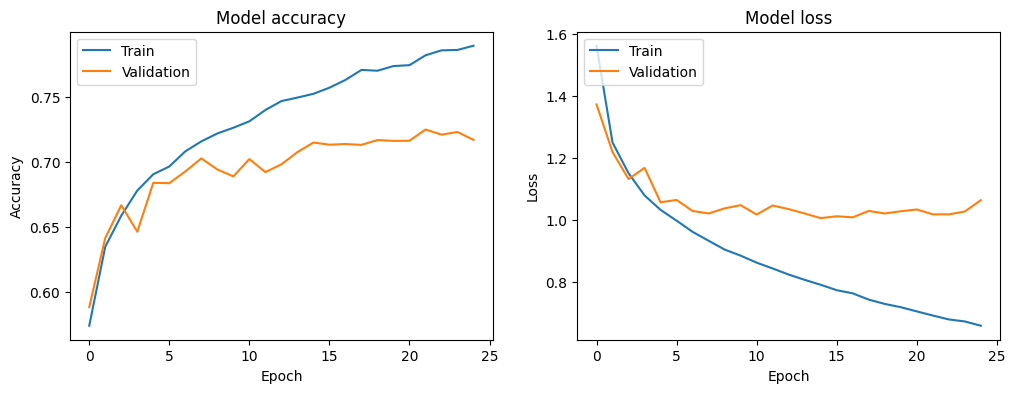

                        Filename        Prediction  Confidence  Correct
0  213_20210905050256_2415_t.jpg      Cicadellidae    0.892392    False
1   192_20200724194326_17604.jpg  Panorpa vulgaris    0.999947    False
2   294_20210814023615_30831.jpg          Caenidae    0.982454    False
3   146_20200616021921_26547.jpg      Chironomidae    0.678275    False
4   118_20200827021322_36091.jpg          Caenidae    0.937080    False
          name                               ancestors
0     Animalia                            ['Animalia']
1      Insecta                 ['Insecta', 'Animalia']
2  Hymenoptera  ['Hymenoptera', 'Insecta', 'Animalia']
3  Lepidoptera  ['Lepidoptera', 'Insecta', 'Animalia']
4      Diptera      ['Diptera', 'Insecta', 'Animalia']


In [4]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Display the first few rows of the output to check
print(results.head())

# Display the family tree information using standard print
print(family_tree_df.head())

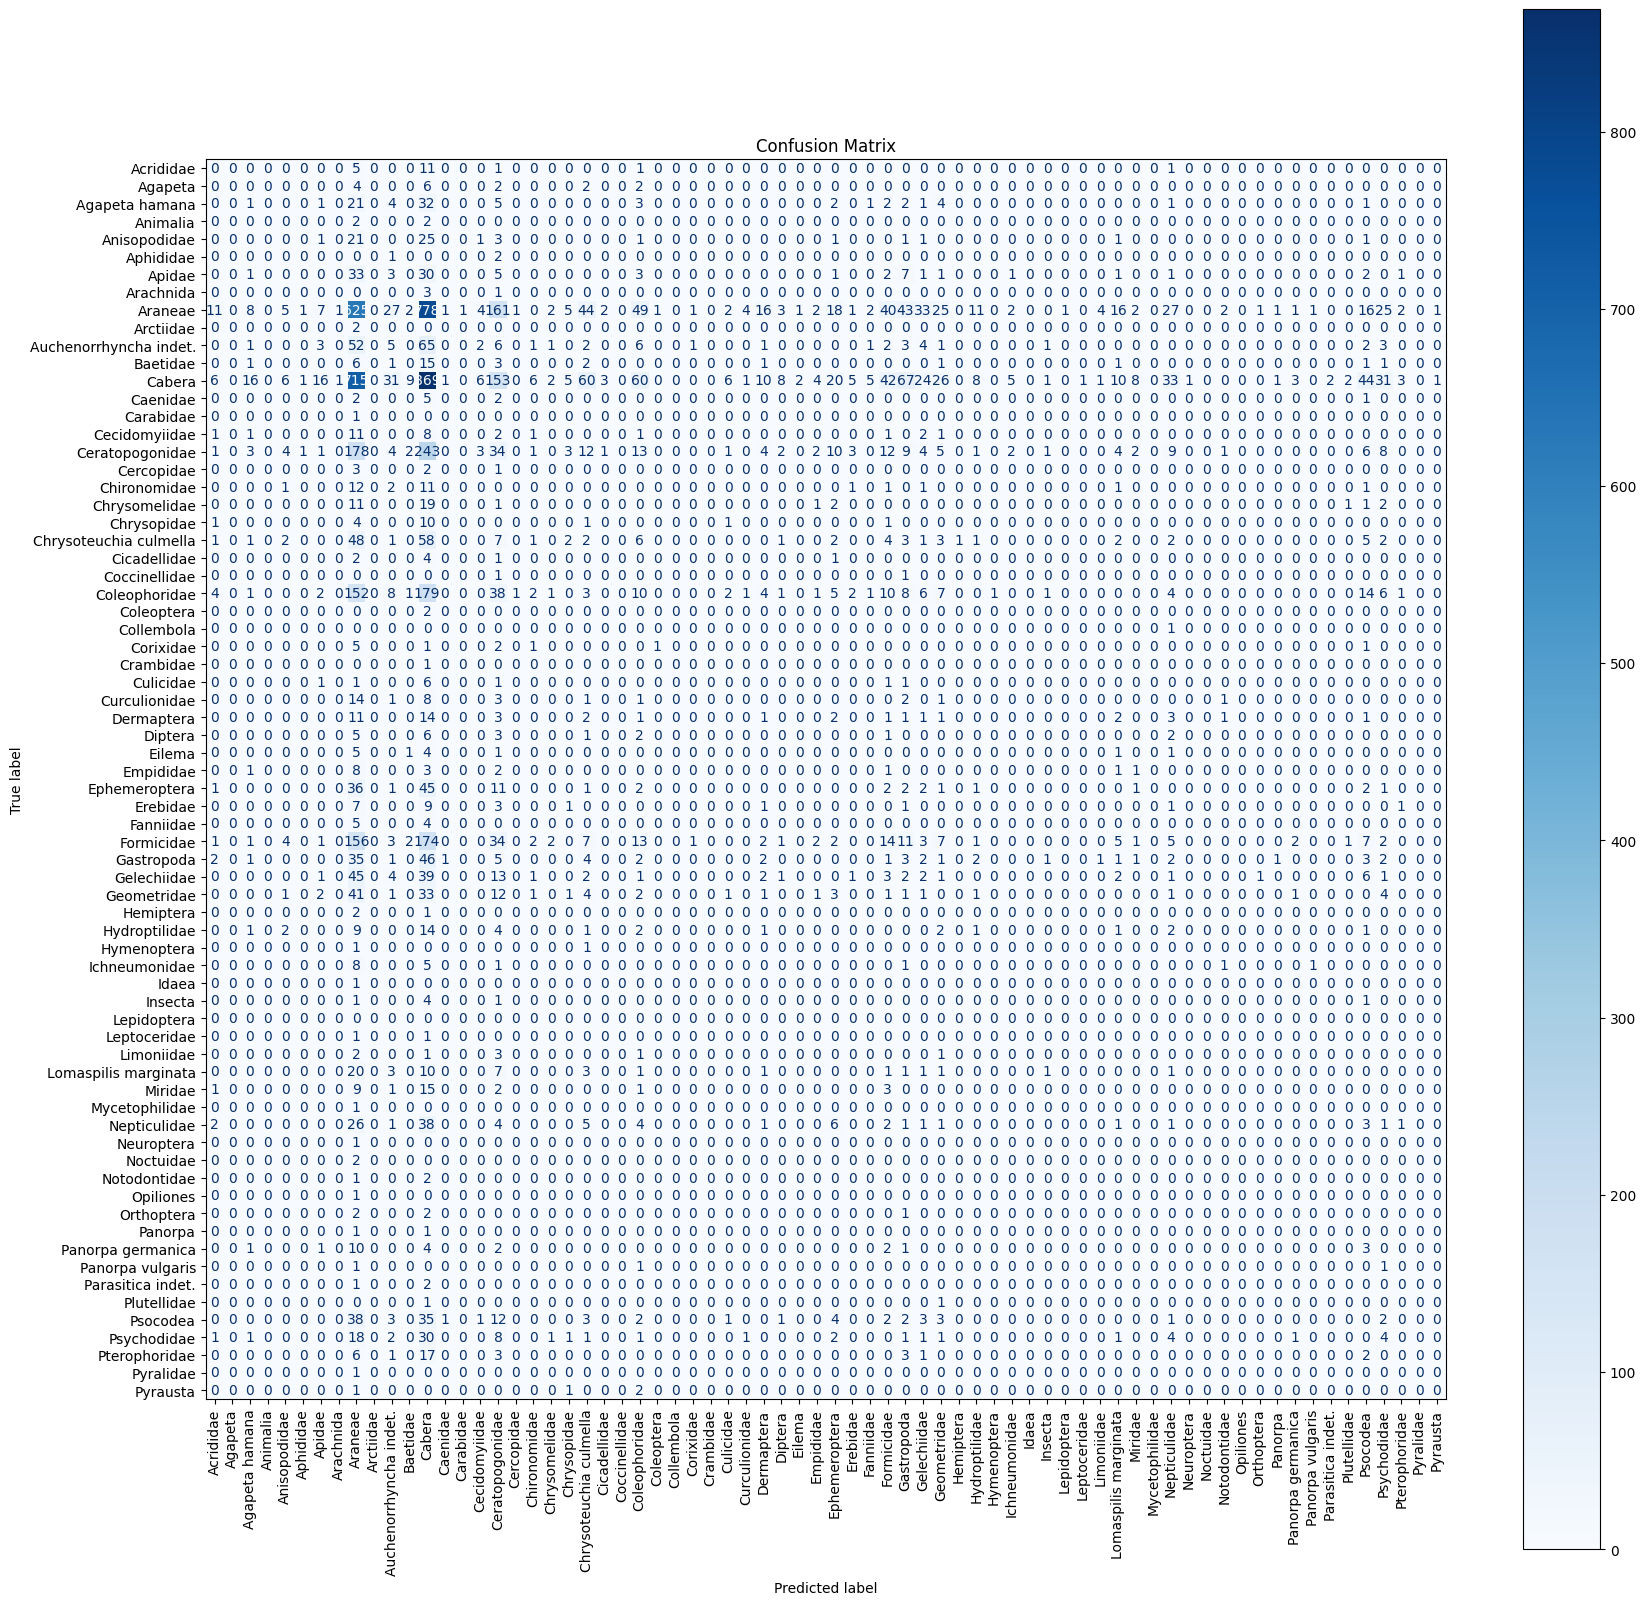

In [5]:
# Import necessary libraries
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_class_indices)

# Get the class names
class_names = list(labels.values())

# Display the confusion matrix with larger figure size and rotated labels
fig, ax = plt.subplots(figsize=(20, 20))  # Increase the figure size
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names[:cm.shape[0]])
disp.plot(cmap='Blues', ax=ax)
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.yticks(rotation=0)   # Ensure y-axis labels are horizontal
plt.title('Confusion Matrix')
plt.show()
